In [4]:
"""
16 September 2021 
Abraham Tishelman-Charny 

The purpose of this notebook is to compute background efficiencies from the 13 TeV HHWWgg analysis in order to understand what to expect from 14 TeV background samples. 
"""

'\n16 September 2021 \nAbraham Tishelman-Charny \n\nThe purpose of this notebook is to compute background efficiencies from the 13 TeV HHWWgg analysis in order to understand what to expect from 14 TeV background samples. \n'

In [5]:
import uproot 
import os 
import pandas as pd 
from tabulate import tabulate
from matplotlib import pyplot as plt 
import numpy as np 

In [17]:
!pip install --user openpyxl

In [6]:
d = "/eos/user/a/atishelm/ntuples/HHWWgg_flashgg/January_2021_Production/2017/Backgrounds/"

In [9]:
files = ["%s/%s"%(d, f) for f in os.listdir(d)]

In [10]:
files

['/eos/user/a/atishelm/ntuples/HHWWgg_flashgg/January_2021_Production/2017/Backgrounds//DYJetsToLL_M-50.root',
 '/eos/user/a/atishelm/ntuples/HHWWgg_flashgg/January_2021_Production/2017/Backgrounds//DiPhotonJetsBox_M40_80.root',
 '/eos/user/a/atishelm/ntuples/HHWWgg_flashgg/January_2021_Production/2017/Backgrounds//DiPhotonJetsBox_MGG-80toInf.root',
 '/eos/user/a/atishelm/ntuples/HHWWgg_flashgg/January_2021_Production/2017/Backgrounds//GJet_Pt-20to40.root',
 '/eos/user/a/atishelm/ntuples/HHWWgg_flashgg/January_2021_Production/2017/Backgrounds//GJet_Pt-20toInf.root',
 '/eos/user/a/atishelm/ntuples/HHWWgg_flashgg/January_2021_Production/2017/Backgrounds//GJet_Pt-40toInf.root',
 '/eos/user/a/atishelm/ntuples/HHWWgg_flashgg/January_2021_Production/2017/Backgrounds//GluGluHToGG.root',
 '/eos/user/a/atishelm/ntuples/HHWWgg_flashgg/January_2021_Production/2017/Backgrounds//QCD_Pt-30to40.root',
 '/eos/user/a/atishelm/ntuples/HHWWgg_flashgg/January_2021_Production/2017/Backgrounds//QCD_Pt-30toI

In [28]:
NfilesToRun = -1
tags = [i for i in range(0, 4)] ##-- Define trees to access 
procs, cuts, values, Ratio_values = [], ["GEN", "MicroAOD", "Diphoton preselection", "exactly one lepton"], [], [] ##-- Initialize datasets for dataframe 

##-- For unweighted efficiencies 
inc_procs, inc_cuts, inc_values, inc_Ratio_values = [], ["GEN", "MicroAOD", "Diphoton preselection", "exactly one lepton"], [], [] ##-- Initialize datasets for dataframe 

##-- For weighted yields 
weighted_values = []
inc_weighted_values = [] 

procs_to_skip = ["TTToHadronic"]
lumi = 41.5 

##-- Inclusive:
pT_inclusive_procs = [
    "W1JetsToLNu", "W2JetsToLNu", "TTJets", "GJet", "QCD"
]

for inc_proc in pT_inclusive_procs:
    exec("%s_GEN_sum = 0"%(inc_proc))
    exec("%s_MicroAOD_sum = 0"%(inc_proc))
    exec("%s_presel_sum = 0"%(inc_proc))
    exec("%s_oneLep_sum = 0"%(inc_proc))
    
    ##-- weighted sums 
    exec("%s_presel_weighted_sum = 0"%(inc_proc))
    exec("%s_oneLep_weighted_sum = 0"%(inc_proc))    

##-- Define number of GEN events per process (from DAS) in order to compute efficiencies w.r.t. GEN 
GEN_events = {
    "DYJetsToLL_M-50" : [180884372], 
    "DiPhotonJetsBox_M40_80" : [3789599] ,
    "DiPhotonJetsBox_MGG-80toInf" : [50851711] ,
    "GJet_Pt-20to40" : [35284140] ,
    "GJet_Pt-20toInf" : [40198250] ,
    "GJet_Pt-40toInf" : [158315792] ,
    "GluGluHToGG" : [1995838] ,
    "QCD_Pt-30to40" : [14594575] ,
    "QCD_Pt-30toInf" : [41974430] ,
    "QCD_Pt-40toInf" : [20277088] ,
    "THQ_ctcvcp" : [1897499] ,
    "TTGG_0Jets" : [1496000] ,
    "TTGJets_TuneCP5" : [9402772] ,
    "TTJets_HT-1200to2500" : [15095] ,
    "TTJets_HT-2500toInf" : [6790] ,
    "TTJets_HT-600to800" : [77688] ,
    "TTJets_HT-800to1200" : [41446] ,
#     "TTToHadronic" : 
    "VBFHToGG" : [1925302] ,
    "VHToGG" : [565594] ,
    
    ##-- For WJets have [GEN, MicroAOD]
    "W1JetsToLNu_LHEWpT_0-50" : [117088386, 4366] ,
    "W1JetsToLNu_LHEWpT_50-150" : [88882941 , 13599 ],
    "W1JetsToLNu_LHEWpT_150-250" : [258842513  + 108925160 , 47897 + 113584 ],
    "W1JetsToLNu_LHEWpT_250-400" : [42817232, 32290],
    "W1JetsToLNu_LHEWpT_400-inf" : [4465538 + 9066797  , 7116 + 11470 ],
    
    "W2JetsToLNu_LHEWpT_0-50" : [104070705, 8812],
    "W2JetsToLNu_LHEWpT_50-150" : [35696676  + 38825622 , 6905  + 7482 ],
    "W2JetsToLNu_LHEWpT_150-250" : [170437978  + 326277287 , 78123 + 151022 ],
    "W2JetsToLNu_LHEWpT_250-400" : [143562166 , 102984 ],
    "W2JetsToLNu_LHEWpT_400-inf" : [60722664 , 65864 ],
    "W3JetsToLNu" : [19700377 , 2766 ],
    "W4JetsToLNu" : [11103685 , 2502  ],
    "WGGJets" : [182221797] ,
#     "WGJJToLNuGJJ_EWK" : 
    "WGJJToLNu_EWK_QCD" : [7500] ,
    "WWTo1L1Nu2Q" : [3256] ,
    "WW_TuneCP5" : [7791498] ,
    "ttHJetToGG" : [389398] ,
    "ttWJets": [17821]             
}

N_files = len(files)

for f_i, f in enumerate(files): ##-- 
    print("On file %s / %s"%(f_i, N_files))
    proc_values, proc_Ratio_values = [], []
    proc_weighted_values = [] 
    procName = f.split('/')[-1]
    procName = procName.replace(".root", "")
    if("WGJJToLNuGJJ_EWK" in procName): continue 
    if(procName in procs_to_skip): continue 
    procs.append(procName)
    u_f = uproot.open(f)
    trees = u_f.keys()
    trees = [tree.replace(";1","") for tree in trees]
    for tag in tags:
        exec("Num_Entries_Tag_%s = len(u_f[trees[tag]]['CMS_hgg_mass'].array())"%(tag))
        exec("weights_Tag_%s = u_f[trees[tag]]['weight'].array()"%(tag))
        exec("Yield_Tag_%s = lumi*np.sum(weights_Tag_%s)"%(tag, tag))
        
    Yield_presel = float(Yield_Tag_0) + float(Num_Entries_Tag_1) + float(Num_Entries_Tag_2) + float(Num_Entries_Tag_3)
    Yield_oneLep = float(Yield_Tag_0)
        
    N_entries_presel = float(Num_Entries_Tag_0) + float(Num_Entries_Tag_1) + float(Num_Entries_Tag_2) + float(Num_Entries_Tag_3)
    N_entries_oneLep = float(Num_Entries_Tag_0) 

    N_entries_GEN = -1 

    pre_Events = GEN_events[procName]

    if(len(pre_Events) == 2):
        N_entries_GEN = pre_Events[0]
        N_entries_MicroAOD = pre_Events[1]
    else:
        N_entries_GEN = pre_Events[0] 
        N_entries_MicroAOD = pre_Events[0]     

    proc_values.append(int(N_entries_GEN))
    proc_values.append(int(N_entries_MicroAOD))
    proc_values.append(int(N_entries_presel))
    proc_values.append(int(N_entries_oneLep))
    
    proc_weighted_values.append(-1)
    proc_weighted_values.append(-1)
    proc_weighted_values.append(float(Yield_presel))
    proc_weighted_values.append(float(Yield_oneLep))

    ##-- If the process is in one of the inclusive categories of interest, add its entries 
    for inclusive_proc in pT_inclusive_procs:
        if(inclusive_proc in procName):
            ##-- Add to inclusive total
            exec("%s_GEN_sum += int(N_entries_GEN)"%(inclusive_proc))
            exec("%s_MicroAOD_sum += int(N_entries_MicroAOD)"%(inclusive_proc))
            exec("%s_presel_sum += int(N_entries_presel)"%(inclusive_proc))
            exec("%s_oneLep_sum += int(N_entries_oneLep)"%(inclusive_proc))
            
            ##-- Weighted
            exec("%s_presel_weighted_sum += float(Yield_presel)"%(inclusive_proc))
            exec("%s_oneLep_weighted_sum += float(Yield_oneLep)"%(inclusive_proc))            

    proc_Ratio_values.append(1)
    proc_Ratio_values.append(float(float(N_entries_MicroAOD) / float(N_entries_GEN)))
    proc_Ratio_values.append(float(float(N_entries_presel) / float(N_entries_GEN)))
    proc_Ratio_values.append(float(float(N_entries_oneLep) / float(N_entries_GEN)))

    values.append(proc_values)
    weighted_values.append(proc_weighted_values)
    Ratio_values.append(proc_Ratio_values)

    if(f_i == NfilesToRun):
        break
    
for inclusive_proc in pT_inclusive_procs:
    exec("proc_N_entries_GEN = %s_GEN_sum"%(inclusive_proc))
    exec("proc_N_entries_MicroAOD = %s_MicroAOD_sum"%(inclusive_proc))
    exec("proc_N_entries_presel = %s_presel_sum"%(inclusive_proc))
    exec("proc_N_entries_oneLep = %s_oneLep_sum"%(inclusive_proc))
    
    exec("proc_N_weighted_entries_presel = %s_presel_weighted_sum"%(inclusive_proc))
    exec("proc_N_weighted_entries_oneLep = %s_oneLep_weighted_sum"%(inclusive_proc))    

    inc_proc_values, inc_proc_Ratio_values = [], []
    inc_proc_weighted_values = [] 

    inc_proc_values.append(int(proc_N_entries_GEN))
    inc_proc_values.append(int(proc_N_entries_MicroAOD))
    inc_proc_values.append(int(proc_N_entries_presel))
    inc_proc_values.append(int(proc_N_entries_oneLep))
    
    inc_proc_weighted_values.append(-1)
    inc_proc_weighted_values.append(-1)
    inc_proc_weighted_values.append(proc_N_weighted_entries_presel)
    inc_proc_weighted_values.append(proc_N_weighted_entries_oneLep)    

    inc_proc_Ratio_values.append(1)
    inc_proc_Ratio_values.append(float(float(proc_N_entries_MicroAOD) / float(proc_N_entries_GEN)))
    inc_proc_Ratio_values.append(float(float(proc_N_entries_presel) / float(proc_N_entries_GEN)))
    inc_proc_Ratio_values.append(float(float(proc_N_entries_oneLep) / float(proc_N_entries_GEN)))

    inc_values.append(inc_proc_values)
    inc_weighted_values.append(inc_proc_weighted_values)
    inc_Ratio_values.append(inc_proc_Ratio_values)
    
print("DONE")

On file 0 / 39
On file 1 / 39
On file 2 / 39
On file 3 / 39
On file 4 / 39
On file 5 / 39
On file 6 / 39
On file 7 / 39
On file 8 / 39
On file 9 / 39
On file 10 / 39
On file 11 / 39
On file 12 / 39
On file 13 / 39
On file 14 / 39
On file 15 / 39
On file 16 / 39
On file 17 / 39
On file 18 / 39
On file 19 / 39
On file 20 / 39
On file 21 / 39
On file 22 / 39
On file 23 / 39
On file 24 / 39
On file 25 / 39
On file 26 / 39
On file 27 / 39
On file 28 / 39
On file 29 / 39
On file 30 / 39
On file 31 / 39
On file 32 / 39
On file 33 / 39
On file 34 / 39
On file 35 / 39
On file 36 / 39
On file 37 / 39
On file 38 / 39
DONE


In [29]:
Weighted_Yield_Table = pd.DataFrame(weighted_values, procs, cuts)
Yield_Table = pd.DataFrame(values, procs, cuts)
Ratio_Table = pd.DataFrame(Ratio_values, procs, cuts)

print("inc_values:",inc_values)
print("pT_inclusive_procs:",pT_inclusive_procs)
print("inc_cuts:",inc_cuts)

inclusive_Weighted_Yield_Table = pd.DataFrame(inc_weighted_values, pT_inclusive_procs, inc_cuts)
inclusive_Yield_Table = pd.DataFrame(inc_values, pT_inclusive_procs, inc_cuts)
inclusive_Ratio_Table = pd.DataFrame(inc_Ratio_values, pT_inclusive_procs, inc_cuts)

print("DONE")
# print(tabulate(Yield_Table, headers='keys', tablefmt='psql'))

inc_values: [[630088567, 230322, 47066, 4691], [879593098, 421192, 82978, 8171], [141019, 141019, 30991, 4407], [425422751, 425422751, 1913355, 12637], [76853593, 76853593, 10570, 333]]
pT_inclusive_procs: ['W1JetsToLNu', 'W2JetsToLNu', 'TTJets', 'GJet', 'QCD']
inc_cuts: ['GEN', 'MicroAOD', 'Diphoton preselection', 'exactly one lepton']
DONE


In [30]:
##-- Create an excel version 
Weighted_Yield_Table.to_excel("Weighted_Yield_Table.xlsx")
Yield_Table.to_excel("Yield_Table.xlsx")  
Ratio_Table.to_excel("Ratio_Table.xlsx")  
inclusive_Weighted_Yield_Table.to_excel("inclusive_Weighted_Yield_Table.xlsx")  
inclusive_Yield_Table.to_excel("inclusive_Yield_Table.xlsx")  
inclusive_Ratio_Table.to_excel("inclusive_Ratio_Table.xlsx") 

print("DONE")

DONE


In [31]:
print("Weighted yields:")
print(tabulate(Weighted_Yield_Table, headers='keys', tablefmt='psql', floatfmt=".4f"))

print("Unweighted yields:")
print(tabulate(Yield_Table, headers='keys', tablefmt='psql', floatfmt=".0f"))

print("Efficiencies")
print(tabulate(Ratio_Table, headers='keys', tablefmt='psql', floatfmt=".8f"))

print("pT inclusive weighted yields:")
print(tabulate(inclusive_Weighted_Yield_Table, headers='keys', tablefmt='psql', floatfmt=".4f"))

print("pT inclusive yields:")
print(tabulate(inclusive_Yield_Table, headers='keys', tablefmt='psql', floatfmt=".0f"))

print("pT inclusive efficiencies:")
print(tabulate(inclusive_Ratio_Table, headers='keys', tablefmt='psql', floatfmt=".8f"))

print("-----------------")

print(Weighted_Yield_Table)
print(Yield_Table)
print(Ratio_Table)
print(inclusive_Weighted_Yield_Table)
print(inclusive_Yield_Table)
print(inclusive_Ratio_Table)

Weighted yields:
+-----------------------------+---------+------------+-------------------------+----------------------+
|                             |     GEN |   MicroAOD |   Diphoton preselection |   exactly one lepton |
|-----------------------------+---------+------------+-------------------------+----------------------|
| DYJetsToLL_M-50             | -1.0000 |    -1.0000 |              10464.3702 |             593.3702 |
| DiPhotonJetsBox_M40_80      | -1.0000 |    -1.0000 |               1367.5319 |              20.5319 |
| DiPhotonJetsBox_MGG-80toInf | -1.0000 |    -1.0000 |            5875389.4641 |             542.4641 |
| GJet_Pt-20to40              | -1.0000 |    -1.0000 |             111966.8943 |              47.8943 |
| GJet_Pt-20toInf             | -1.0000 |    -1.0000 |               6747.1311 |             108.1311 |
| GJet_Pt-40toInf             | -1.0000 |    -1.0000 |            1741619.0394 |             905.0394 |
| GluGluHToGG                 | -1.0000 |    -1

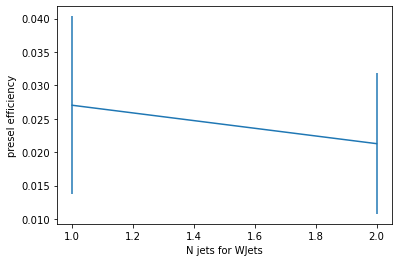

In [33]:
# denoms = [47066, 82978 , 645, 561]
# effs = [0.00007470, 0.00009434, 0.00003274, 0.00005052]

# 14 TeV emenriched 
denoms = [37, 47]
effs = [1./37. , 1./47.]

yerr = []

for i in range(0,2):
    eff = effs[i]
    denom = denoms[i]
    sig_eff = np.sqrt(eff * (1 - eff) / denom)
    yerr.append(sig_eff / 2.)

fig, ax = plt.subplots()
# plt.plot([1, 2, 3, 4], [0.00007470, 0.00009434, 0.00003274, 0.00005052])
# plt.errorbar([1, 2, 3, 4], effs, yerr = yerr)
plt.errorbar([1, 2], effs, yerr = yerr)
plt.xlabel("N jets for WJets")
plt.ylabel("presel efficiency")
plt.show()
plt.close()